Avances de resultados estrategia para la localización Óptima de Sensores de Contaminación Lumínica

In [1074]:
from PIL import Image

import numpy as np

from noisyopt import minimizeCompass

from sortedcontainers import SortedList

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.pylab import rcParams
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib.patches as mpatches

from skimage.feature import peak_local_max
from skimage.segmentation import watershed

from scipy import ndimage as ndi

In [1075]:
def f5(i,p,e=4):
    '''
    Pesos exponenciales
    
    W = i*a^(p-r)
    '''
    return i*e**(p)

def getN(W,i,j):
    ln = ([])
    c = W[i,j]
    ln.append(W[i+1,j])
    ln.append(W[i-1,j])
    ln.append(W[i-1,j-1])
    ln.append(W[i-1,j+1])
    ln.append(W[i+1,j+1])
    ln.append(W[i+1,j-1])
    ln.append(W[i,j+1])
    ln.append(W[i,j-1])
    opt = False if W[i,j]<max(ln) else True
    return opt

def fuerza_puntual(x,y,im2,h=2,e=2):
    '''
    this does not make sense if we have corrected verions solving the saturarion image problem
    
    '''
    s = 0.0 
    g1 = float(im2[x][y])
    xlb = 0 if(x-h)<0 else x-h
    xub = im2.shape[0] if(x+h)> im2.shape[0] else x+h
    
    ylb = 0 if(y-h)<0 else y-h
    yub = im2.shape[1] if(y+h)> (im2.shape[1]) else y+h 
    
    ri = np.arange(xlb,xub)
    rj = np.arange(ylb,yub)
    for i in ri:
        for j in rj:
            d=((i-x)**2+(j-y)**2)**(0.5)
            g2 = float(im2[i][j])
            if d >0: s += (g1*g2)/(d**e)
    return s

def filtro_fuerza_puntual(A,h=3,e=2):
    pot1 = np.zeros(A.shape)
    for i in range(pot1.shape[0]):
        for j in range(pot1.shape[1]):
            pot1[i][j] = fuerza_puntual(i,j,A,h,e)
            
    return pot1


def plot_examples(data,colormaps,filename):
    """
    Helper function to plot data with associated colormap.
    """
    n = len(colormaps)
    #fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
    #                        constrained_layout=False, squeeze=False)
    fig, axs = plt.subplots(1, n, figsize=(6, 5.2),constrained_layout=False, squeeze=False)
   
    scalebar = ScaleBar(1000) # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    for [ax, cmap] in zip(axs.flat, colormaps):
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        psm = ax.pcolormesh(np.flip(data,0), cmap=cmap, rasterized=False, vmin=0, vmax=data.max())
        fig.colorbar(psm, ax=ax)
    
    

    plt.savefig(filename, dpi = 150)

def getMax(img):
    B = np.zeros(img.shape)
    for i in range(1,B.shape[0]-1):
        for j in range(1,B.shape[1]-1):
            B[i][j] = getN(img,i,j)
    
    positionsB = B*(img>0)
    locationsP = np.zeros(nonsat.shape)
    for i in range(0,nonsat.shape[0]):
        for j in range(0,nonsat.shape[1]):
            locationsP[i][j] = 8 if positionsB[i][j]==1 else P[i,j]
    
    
    return positionsB

def get_coords(seeds):
    coords = np.array([[0,0]])
    for i in range(0,seeds.shape[0]):
        for j in range(0,seeds.shape[1]):
            if seeds[i,j]!=0:
                coords = np.append(coords,[[i,j]],axis=0)
    return coords

custom_cmap = cm.get_cmap('hot', 256)
newcolors = custom_cmap(np.linspace(0, 1, 256))
pink = np.array([200/256, 200/256, 200/256, 1])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

Carga de imágenes

In [1076]:
#Original nocturnal image without values <21
im1 = np.array(Image.open('inputs/qro_light_th'))
im1 = np.where(im1==255, 0, im1) 

#Region priorities of Jorge and Lamphar
P = np.array(Image.open('inputs/prioridades'))

#calcular este valor automaticamente
nc = 5

# 0 máxima prioridad
# 4 mínima prioridad (antes espacio nan)
P = np.where(np.isnan(P),nc, P)-1 
P = P.max()-P


im1_gr = filtro_fuerza_puntual(im1,h=3,e=4)

W1 = f5(im1,P)
W2 = f5(im1_gr,P)


# Transformada de la distancia en la región saturada. Usamos esta en vez de la transformación que nos inventamos

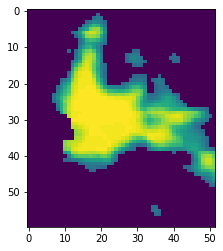

In [1077]:

plt.imshow(im1)

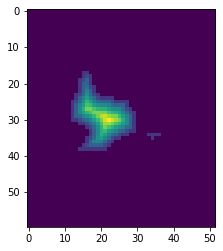

In [1078]:
th = 62

image = im1>=th

distance = ndi.distance_transform_edt(image)

plt.imshow(distance)

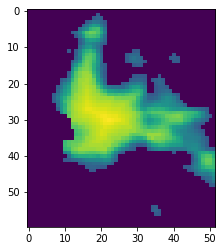

In [1079]:
#Sustituimos la parte saturada en la imagen original.

nons = (im1>=th)*im1

nonsat = im1+(distance*2)
plt.imshow(nonsat)

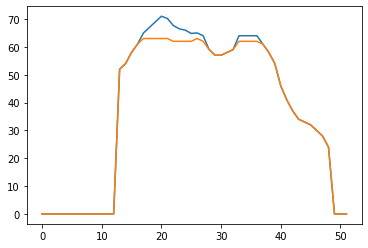

In [1080]:
# Ejemplo Sección desaturada vs original saturada fila 34

plt.plot(nonsat[34,:])
plt.plot(im1[34,:])

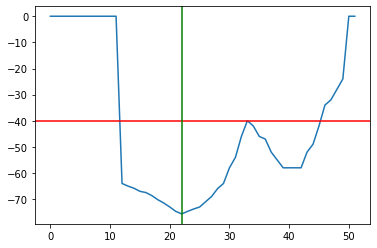

In [1081]:
#  hacemos la analogia del mapa de NTI con la de una cuenca
plt.plot(-nonsat[30,:])
plt.axhline(y=-40, color='r', linestyle='-')
plt.axvline(x=22, color='g', linestyle='-')

#plt.plot(-im1[34,:])

Identificar Picos de la imagen sin las clases P

In [1082]:
p = np.array([30,22])

i = j = 0

p2 = (p + [i,j])
n  = np.linalg.norm(p-p2)
ls = [[n,nonsat[p2[0],p2[1]]]]

for i in range(-20,20):
    for j in range(-20,20):
        p2 = (p + [i,j])
        n = np.linalg.norm(p-p2)
        ls = np.append(ls,[[n,nonsat[p2[0],p2[1]]]],axis = 0)
        

In [1083]:
ls[:,1] = (ls[:,1]-nonsat[p[0],p[1]])**2

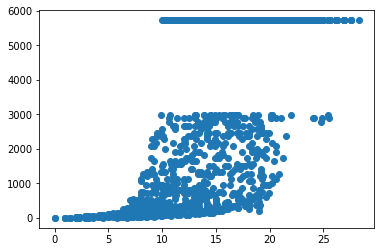

In [1084]:
plt.scatter(ls[:,0],ls[:,1])

In [1339]:
def makeSpatialScatter(pc,mask,img):

    i = j = 0
    
    p = np.array([i,j])
    d = np.linalg.norm(pc-pc)
    v = (img[pc[0],pc[1]]-img[pc[0],pc[1]])**2

    ls = [[d,v]]
    
    for i in range(1,img.shape[0]):
        for j in range(1,img.shape[1]):
            if mask[i][j]==1:
                p = np.array([i,j])

                d = np.linalg.norm(p-pc)
                
                v = (img[p[0],p[1]]-img[pc[0],pc[1]])**2
        
                ls = np.append(ls,[[d,v]],axis = 0)
 
  
                
    return ls

In [1446]:
def variogram(sc,h=30):
    variogram = np.array([])
    for h in range(1,30):


        ix = (sc[:,0]>(h-1))*(sc[:,0]<=h)
        n = np.sum(ix)
        if n >0:
            v = np.sum(sc[ix,1])
            g = v/(2*n)
            variogram = np.append(variogram,g)
        else:
            variogram = np.append(variogram,0)
    
    return variogram

In [1447]:
coords[-6:-5]

array([[35, 34]])

[19 16]


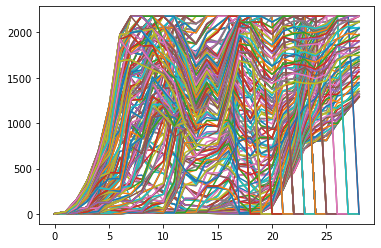

In [1454]:
atol = 30
rs=30
th = 0.0025
setC = np.zeros(nonsat.shape)
f = 1
for c in coords[5:6]:
    print(c)
    dy = c[0]
    dx = c[1]
    setC[dy,dx]=1
    for direction in range(0,359):
        setA = np.zeros(nonsat.shape)
        setB = np.zeros(nonsat.shape)


        gm1 = direction-atol
        gm2 = direction+atol
        m1 = np.tan(np.radians(gm1))
        m2 = np.tan(np.radians(gm2))
        mc = np.tan(np.radians(gm2))

        for y in range(test.shape[0]):
            for x in range(test.shape[1]):

                if gm1<90 or gm1>90*3:
                    setA[y][x] = 1 if m1*(x-dx)+dy-y <0 else 0
                else:
                    setA[y][x] = 0 if m1*(x-dx)+dy-y <0 else 1

                if gm2<90 or gm2>90*3:
                    setB[y][x] = 0 if m2*(x-dx)+dy-y <0 else 1
                else:
                    setB[y][x] = 1 if m2*(x-dx)+dy-y < 0 else 0

        mask = setA*setB
        p = np.array([dy,dx])
        sc = makeSpatialScatter(p,mask,nonsat)
        accum = variogram(sc)

        radio = np.sum(np.cumsum((accum/np.sum(accum)))<th)



        plt.plot(variogram(sc))


        y = np.int(np.round(radio*np.sin(np.radians(direction))))
        x = np.int(np.round(radio*np.cos(np.radians(direction))))
        
        py = nonsat.shape[0]-1 if dy+y>=nonsat.shape[0] else dy+y
        px = nonsat.shape[1]-1 if dx+x>=nonsat.shape[1] else dx+x


        setC[py,px]=f
        
    f+=10
    
    
    
    
    


In [1457]:
sc

array([[   0.        ,    0.        ],
       [  34.13209633, 4356.        ],
       [  34.98571137, 4356.        ],
       ...,
       [  38.91015292, 4356.        ],
       [  38.47076812, 4356.        ],
       [  39.35733731, 4356.        ]])

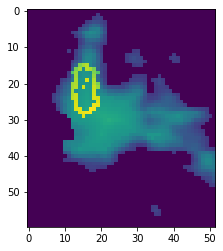

In [1461]:
plt.imshow(setC*50+seeds+nonsat)

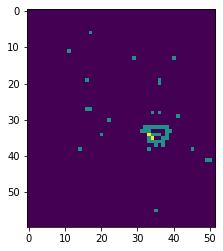

In [1442]:
plt.imshow(setC+seeds)

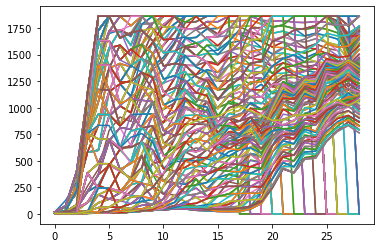

In [1385]:


atol = 45

#    print(m1,m2)
dx = 22
dy = 30

dx = 14
dy = 38




rs=40
h = 5
setC = np.zeros(nonsat.shape)
setC[dy,dx]=1
th = 0.0025
for direction in range(0,359):
    setA = np.zeros(nonsat.shape)
    setB = np.zeros(nonsat.shape)

    
    gm1 = direction-atol
    gm2 = direction+atol
    m1 = np.tan(np.radians(gm1))
    m2 = np.tan(np.radians(gm2))
    mc = np.tan(np.radians(gm2))

    for y in range(test.shape[0]):
        for x in range(test.shape[1]):
            
            if gm1<90 or gm1>90*3:
                setA[y][x] = 1 if m1*(x-dx)+dy-y <0 else 0
            else:
                setA[y][x] = 0 if m1*(x-dx)+dy-y <0 else 1
            
            if gm2<90 or gm2>90*3:
                setB[y][x] = 0 if m2*(x-dx)+dy-y <0 else 1
            else:
                setB[y][x] = 1 if m2*(x-dx)+dy-y < 0 else 0
    
    mask = setA*setB
    p = np.array([dy,dx])
    sc = makeSpatialScatter(p,mask,nonsat)
    accum = variogram(sc)

    radio = np.sum(np.cumsum((accum/np.sum(accum)))<th)

    
    
    plt.plot(variogram(sc))

    
    y = np.int(np.round(radio*np.sin(np.radians(direction))))
    x = np.int(np.round(radio*np.cos(np.radians(direction))))
    
    
    setC[dy+y,dx+x]=1


    
    

    

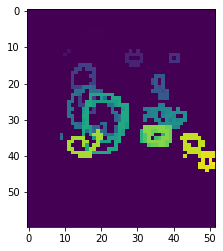

In [1407]:
plt.imshow(setC*100+nonsat)

In [1410]:
coords

array([[ 0,  0],
       [ 6, 17],
       [11, 11],
       [13, 29],
       [13, 40],
       [19, 16],
       [19, 36],
       [20, 36],
       [27, 16],
       [27, 17],
       [28, 34],
       [28, 36],
       [29, 41],
       [30, 22],
       [34, 20],
       [34, 33],
       [34, 34],
       [34, 35],
       [34, 36],
       [35, 34],
       [38, 14],
       [38, 45],
       [41, 49],
       [41, 50],
       [55, 35]])

6

In [ ]:
def getD(accum,th=0.005):
    np.cumsum((accum/np.sum(accum)))<th
    
    

In [1338]:
sc

array([[0.00000000e+00, 0.00000000e+00],
       [2.84604989e+01, 5.72278794e+03],
       [2.94108823e+01, 5.72278794e+03],
       [3.03644529e+01, 5.72278794e+03],
       [2.52982213e+01, 5.72278794e+03],
       [2.62488095e+01, 5.72278794e+03],
       [2.72029410e+01, 5.72278794e+03],
       [2.81602557e+01, 5.72278794e+03],
       [2.91204396e+01, 5.72278794e+03],
       [3.00832179e+01, 5.72278794e+03],
       [2.21359436e+01, 5.72278794e+03],
       [2.30867928e+01, 5.72278794e+03],
       [2.40416306e+01, 5.72278794e+03],
       [2.50000000e+01, 5.72278794e+03],
       [2.59615100e+01, 5.72278794e+03],
       [2.69258240e+01, 5.72278794e+03],
       [2.78926514e+01, 5.72278794e+03],
       [2.88617394e+01, 5.72278794e+03],
       [2.98328678e+01, 5.72278794e+03],
       [1.89736660e+01, 1.90524486e+03],
       [1.99248588e+01, 2.46503419e+03],
       [2.08806130e+01, 5.72278794e+03],
       [2.18403297e+01, 5.72278794e+03],
       [2.28035085e+01, 5.72278794e+03],
       [2.376972

In [1328]:
h = np.sqrt(2)
y = h*np.sin(np.radians(0))
x = h*np.cos(np.radians(0))

print(h)

1.4142135623730951


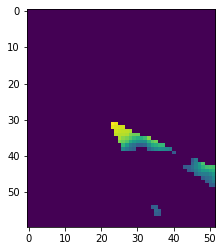

In [1285]:
plt.imshow(mask*nonsat)

In [1270]:
sc

array([[0.00000000e+00, 0.00000000e+00],
       [3.00832179e+01, 5.72278794e+03],
       [3.10161248e+01, 5.72278794e+03],
       [2.69258240e+01, 5.72278794e+03],
       [2.78567766e+01, 5.72278794e+03],
       [2.87923601e+01, 5.72278794e+03],
       [2.97321375e+01, 5.72278794e+03],
       [3.06757233e+01, 5.72278794e+03],
       [2.46981781e+01, 5.72278794e+03],
       [2.56320112e+01, 5.72278794e+03],
       [2.65706605e+01, 5.72278794e+03],
       [2.75136330e+01, 5.72278794e+03],
       [2.84604989e+01, 5.72278794e+03],
       [2.94108823e+01, 5.72278794e+03],
       [3.03644529e+01, 5.72278794e+03],
       [2.15406592e+01, 5.72278794e+03],
       [2.24722051e+01, 5.72278794e+03],
       [2.34093998e+01, 5.72278794e+03],
       [2.43515913e+01, 5.72278794e+03],
       [2.52982213e+01, 5.72278794e+03],
       [2.62488095e+01, 5.72278794e+03],
       [2.72029410e+01, 5.72278794e+03],
       [2.81602557e+01, 5.72278794e+03],
       [2.91204396e+01, 5.72278794e+03],
       [3.008321

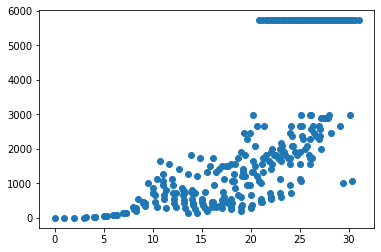

In [1271]:
sc

plt.scatter(sc[:,0],sc[:,1])

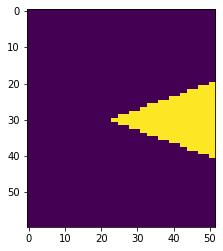

In [1241]:
plt.imshow(mask)

In [1242]:
sc



array([[0.00000000e+00, 0.00000000e+00],
       [2.97321375e+01, 5.72278794e+03],
       [3.06757233e+01, 5.72278794e+03],
       [2.65706605e+01, 5.72278794e+03],
       [2.75136330e+01, 5.72278794e+03],
       [2.84604989e+01, 5.72278794e+03],
       [2.94108823e+01, 5.72278794e+03],
       [3.03644529e+01, 5.72278794e+03],
       [2.34093998e+01, 5.72278794e+03],
       [2.43515913e+01, 5.72278794e+03],
       [2.52982213e+01, 5.72278794e+03],
       [2.62488095e+01, 5.72278794e+03],
       [2.72029410e+01, 5.72278794e+03],
       [2.81602557e+01, 5.72278794e+03],
       [2.91204396e+01, 5.72278794e+03],
       [3.00832179e+01, 5.72278794e+03],
       [2.11896201e+01, 5.72278794e+03],
       [2.21359436e+01, 5.72278794e+03],
       [2.30867928e+01, 5.72278794e+03],
       [2.40416306e+01, 5.72278794e+03],
       [2.50000000e+01, 5.72278794e+03],
       [2.59615100e+01, 5.72278794e+03],
       [2.69258240e+01, 5.72278794e+03],
       [2.78926514e+01, 5.72278794e+03],
       [2.886173

In [1197]:
nonsat[30,22]

75.64911064067351

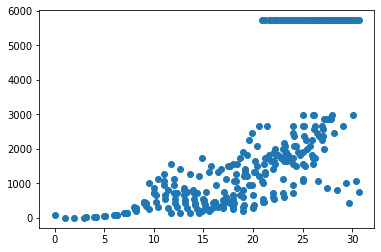

In [1190]:
p = np.array([30,22])
sc = makeSpatialScatter(p,setA*setB,nonsat)
plt.scatter(sc[:,0],sc[:,1])

/Users/rodrigo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


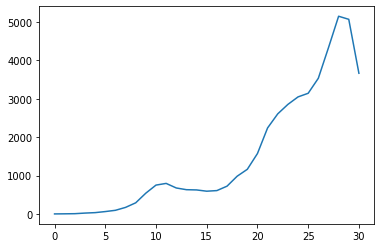

In [1243]:
h = 40
L = list([])
for h in range(1,h):
    n = np.sum(((sc[:,0]<=h)*(sc[:,0]>(h-1))*[sc[:,1]])>0)
    v = np.sum(((sc[:,0]<=h)*(sc[:,0]>(h-1))*[sc[:,1]]))
    L.append(v/n)

    
plt.plot(L)

In [1258]:

variogram = np.array([])
for h in range(1,30):


    ix = (sc[:,0]>(h-1))*(sc[:,0]<=h)
    n = np.sum(ix)
    v = np.sum(sc[ix,1])
    g = v/(2*n)
    variogram = np.append(variogram,g)
    
    
    

In [1282]:
def variogram(sc,h=30):
    variogram = np.array([])
    for h in range(1,30):


        ix = (sc[:,0]>(h-1))*(sc[:,0]<=h)
        n = np.sum(ix)
        if n >0:
            v = np.sum(sc[ix,1])
            g = v/(2*n)
            variogram = np.append(variogram,g)
        else:
            variogram = np.append(variogram,0)
    
    return variogram
    

In [1245]:
#https://scikit-gstat.readthedocs.io/en/latest/userguide/variogram.html

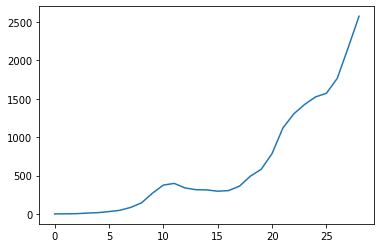

In [1262]:
plt.plot(variogram(sc))

In [507]:
help(np.sort)

Help on function sort in module numpy:

sort(a, axis=-1, kind=None, order=None)
    Return a sorted copy of an array.
    
    Parameters
    ----------
    a : array_like
        Array to be sorted.
    axis : int or None, optional
        Axis along which to sort. If None, the array is flattened before
        sorting. The default is -1, which sorts along the last axis.
    kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
        Sorting algorithm. The default is 'quicksort'. Note that both 'stable'
        and 'mergesort' use timsort or radix sort under the covers and, in general,
        the actual implementation will vary with data type. The 'mergesort' option
        is retained for backwards compatibility.
    
        .. versionchanged:: 1.15.0.
           The 'stable' option was added.
    
    order : str or list of str, optional
        When `a` is an array with fields defined, this argument specifies
        which fields to compare first, second, etc.  A si

In [480]:
p = np.array([30,22])
for h in range(30):

    nonsat[p]-nonsat[p[0],p[1]+h]

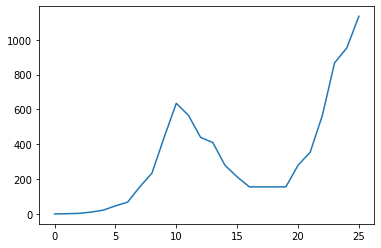

In [485]:
s = list([])
for h in range(1,27):

    z  = nonsat[p[0],p[1]]
    zh = nonsat[p[0],p[1]+h]


    s.append(0.5*(z-zh)**2)

    
plt.plot(s)

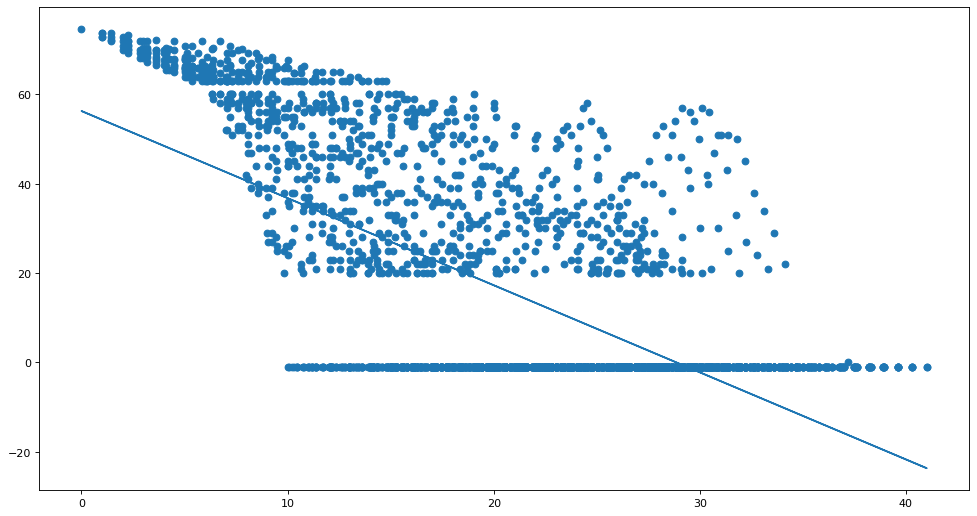

In [486]:
np.random.shuffle(ls)
plt.figure(figsize=(15, 8), dpi=80)
plt.scatter(ls[:,0],ls[:,1])
x = ls[:,0]
y = ls[:,1]
m, b = np.polyfit(x, y, 1)



plt.plot(x, m*x + b)

plt.show()

In [490]:
ls

ls

array([[-1.        , 17.02938637],
       [13.92838828, 32.        ],
       [-1.        , 25.49509757],
       ...,
       [-1.        , 25.17935662],
       [-1.        , 26.30589288],
       [-1.        , 15.29705854]])

In [ ]:
def variogram(image, p, direction, tolerance):
    '''
    image: raster image
    p: central point
    direction: degrees
    tolerance: tolerance un grades
    '''
    
    m = 
    

In [446]:
x
    

[-2.1, -1, 4.3]

In [432]:
np.cov(ls)

array([[297.90939982, 340.59958832, 263.81103422, ..., 410.68394668,
         73.22819946, 233.24121628],
       [340.59958832, 389.40724809, 301.61495308, ..., 469.53464125,
         83.72174428, 266.66450369],
       [263.81103422, 301.61495308, 233.61552813, ..., 363.67753677,
         64.84658438, 206.54469623],
       ...,
       [410.68394668, 469.53464125, 363.67753677, ..., 566.14965543,
        100.9489663 , 321.53541744],
       [ 73.22819946,  83.72174428,  64.84658438, ..., 100.9489663 ,
         18.        ,  57.33231083],
       [233.24121628, 266.66450369, 206.54469623, ..., 321.53541744,
         57.33231083, 182.61077028]])

In [433]:
x = [-2.1, -1,  4.3]
y = [3,  1.1,  0.12]
X = np.stack((x, y), axis=0)



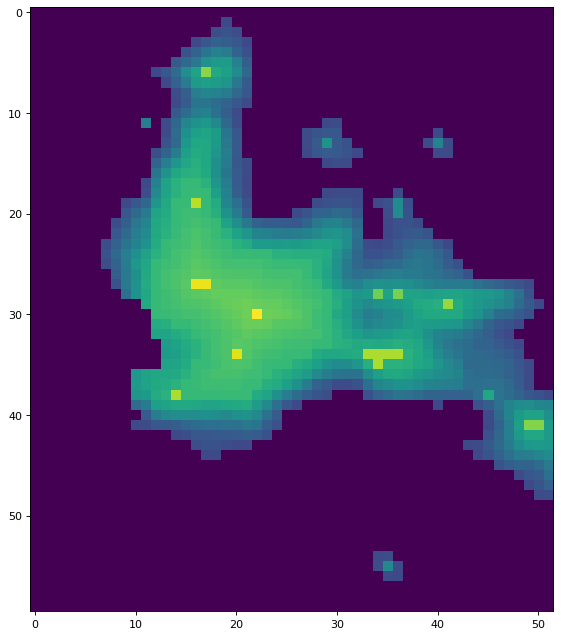

In [1462]:
seeds = getMax(nonsat)
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(seeds*20+nonsat)

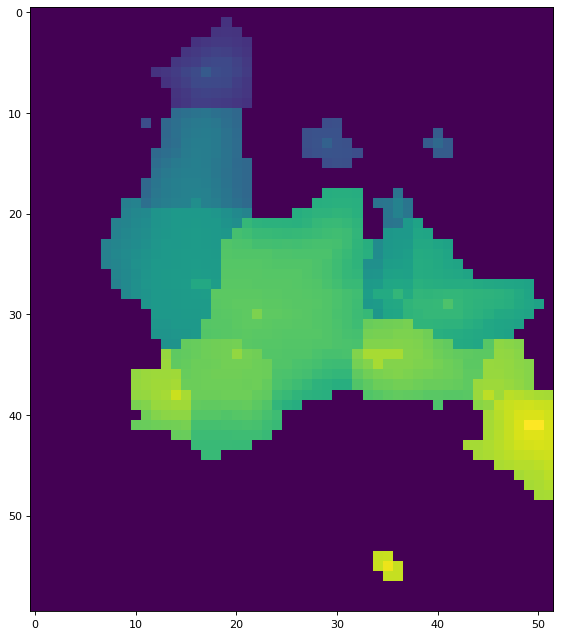

In [444]:
coords = get_coords(seeds) 

mask = np.zeros(im1.shape, dtype=bool)
mask[tuple(coords.T)] = True

markers, _ = ndi.label(mask)
labels = watershed(-nonsat, markers, mask=im1)

plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(labels*20+nonsat+seeds*20)

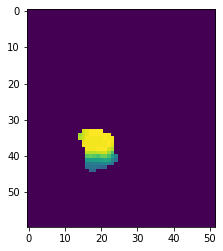

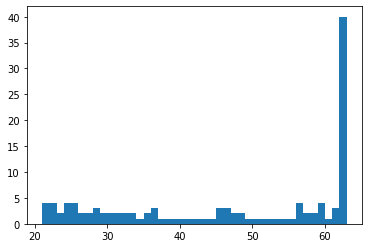

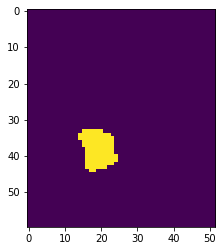

In [395]:
region_all = np.zeros(im1.shape)



l = 13
sample = im1*(labels==l)
plt.imshow(sample)
plt.show()

plt.hist(sample.flatten(),bins=np.unique(sample.flatten())[1:])
plt.show()

masksize = np.sum(sample.flatten()>0)
lightpeak = sample.flatten().max()

region_all =region_all + (labels==l)*lightpeak    
plt.imshow(region_all) 


#l=4
#sample = im1*(labels==l)
#masksize = np.sum(sample.flatten()>0)
#lightpeak = sample.flatten().max()


#region_all =region_all + (labels==l)*((labels==l)*lightpeak)
#plt.imshow(region_all+seeds*10)


#plt.show()



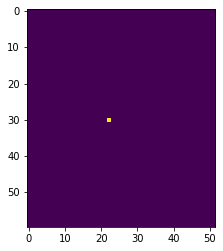

In [166]:
seed  = ((seeds>0) & (sample>0))
plt.imshow(seed)
plt.show()

plt.imshow(seed)
plt.show()

[30, 22]


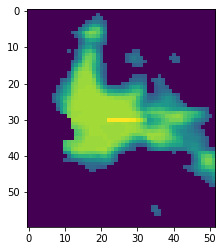

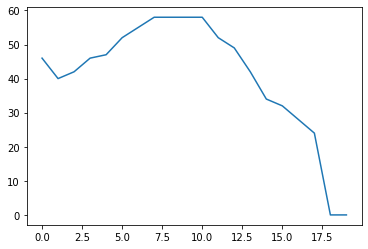

In [396]:
from skimage.draw import line_aa

c = np.where(seed == True)
coordinate = [c[0][0],c[1][0]]
print(coordinate)

img = np.zeros(seed.shape, dtype=np.uint8)

plt.imshow(img)

rr, cc, val = line_aa(30, 22, 30, 32)


img[rr, cc] = 1
plt.imshow(im1+img*10)
plt.show()

plt.plot(nonsat[30,32:])

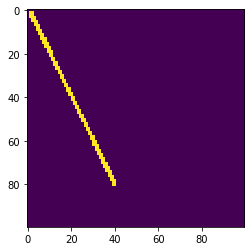

In [204]:
import scipy.misc
import numpy as np
from skimage.draw import line_aa
img = np.zeros((100, 100), dtype=np.uint8)
rr, cc, val = line_aa(1, 1, 80, 40)
img[rr, cc] = 1
plt.imshow(img)

In [112]:
l = np.unique(labels.flatten())

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18], dtype=int32)

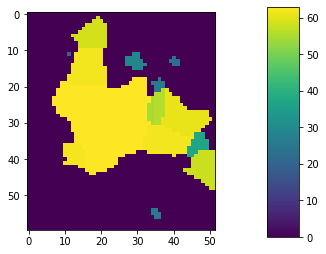

In [123]:
region_all = np.zeros(im1.shape)

for l in np.unique(labels.flatten()):
    sample = im1*(labels==l)
    masksize = np.sum(sample.flatten()>0)
    lightpeak = sample.flatten().max()
    region_all =region_all + (labels==l)*lightpeak    


plt.imshow(region_all)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

plt.show()

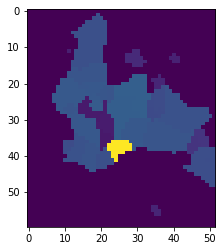

In [132]:
plt.imshow(region_all-im1)

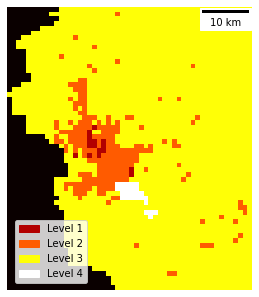

In [124]:
# Considerando la combinacion del mapa de NLTT y las clases P

data = P

# get the unique values from data
# i.e. a sorted list of all values in data
values = np.unique(data.ravel())

plt.figure(figsize=(6, 5.2))
im = plt.imshow(data,cmap = plt.cm.hot)

# get the colors of the values, according to the 
# colormap used by imshow
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=int(values[i])) ) for i in range(1,5) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(0.33, 0.25), loc=1, borderaxespad=0.1 )
plt.axis('off')
scalebar = ScaleBar(1000) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)

plt.savefig("figures/01_importance_level_map.pdf", dpi = 150)

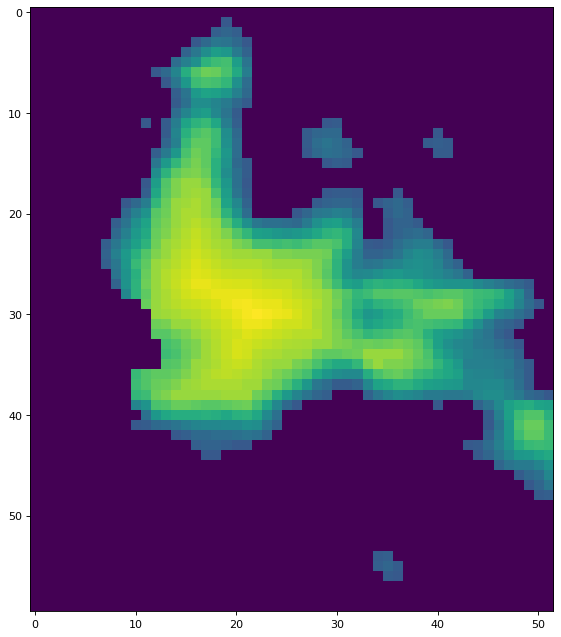

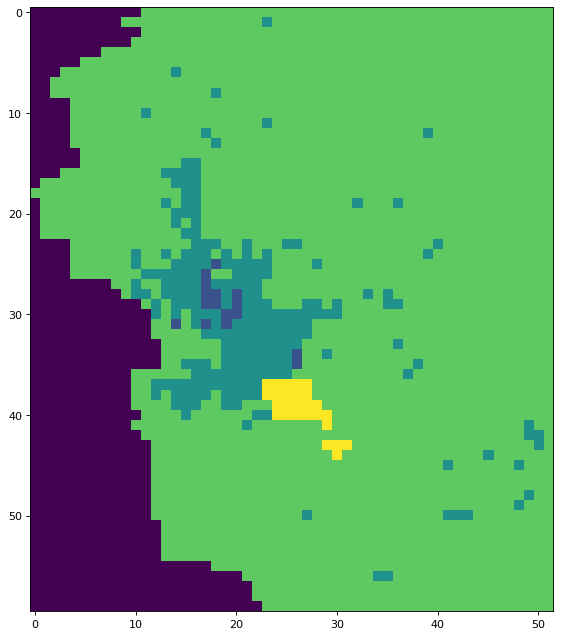

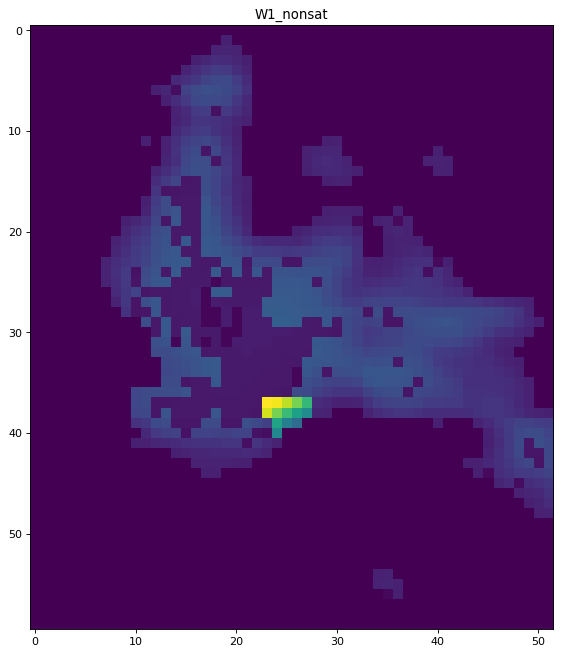

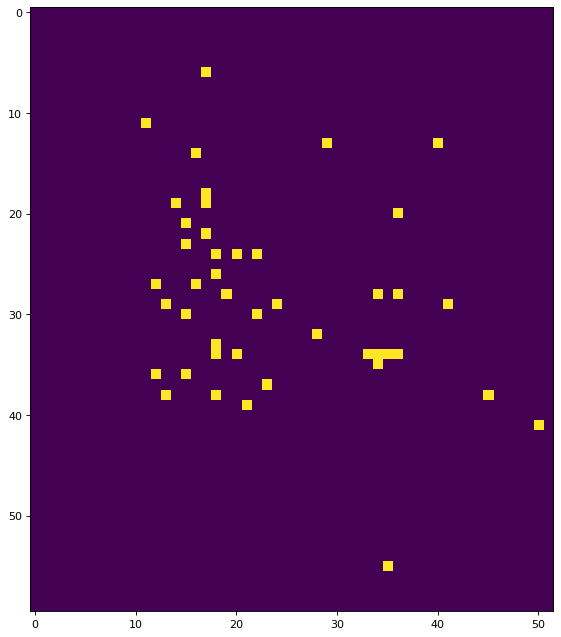

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

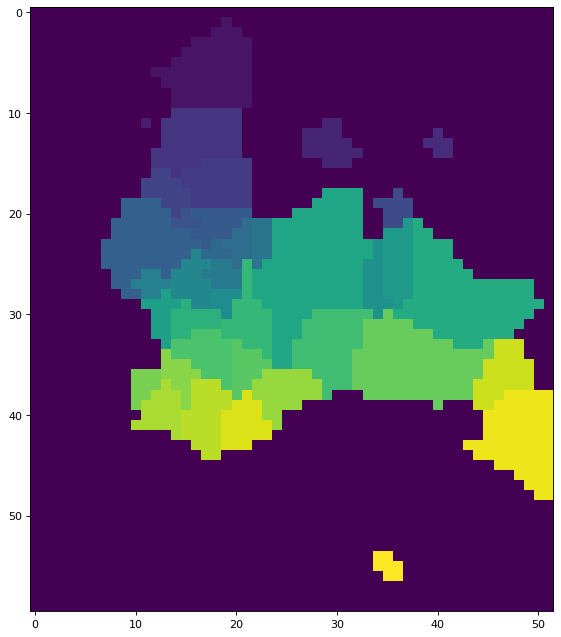

In [129]:
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(nonsat)
plt.show()

plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(P)
plt.show()

plt.figure(figsize=(10, 10), dpi=80)
W1_nonsat = f5(nonsat,P)
plt.title("W1_nonsat")
plt.imshow(W1_nonsat)
plt.show()

plt.figure(figsize=(10, 10), dpi=80)
seeds = getMax(W1_nonsat)
plt.imshow(seeds)
plt.show()

plt.figure(figsize=(10, 10), dpi=80)
coords = get_coords(seeds)

plt.figure(figsize=(10, 10), dpi=80)
mask = np.zeros(W1_nonsat.shape, dtype=bool)
mask[tuple(coords.T)] = True

plt.figure(figsize=(10, 10), dpi=80)
markers, _ = ndi.label(mask)
labels = watershed(-W1_nonsat, markers, mask=W1_nonsat)
plt.imshow(labels)
plt.show()


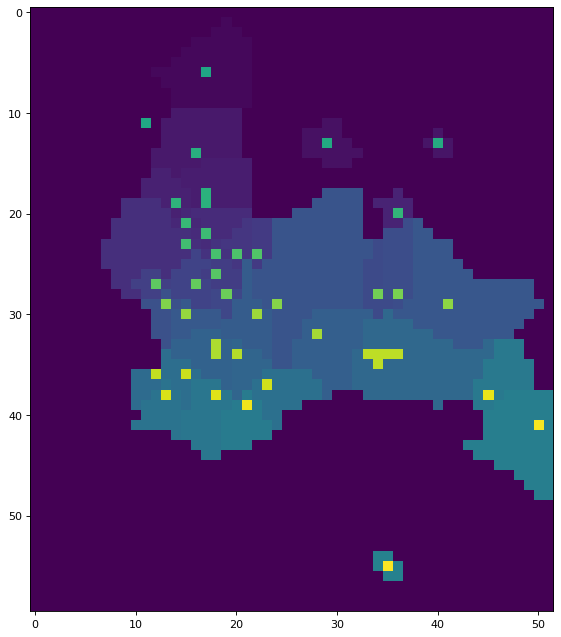

In [126]:
plt.figure(figsize=(10, 10), dpi=80)
plt.imshow(labels+seeds*50)

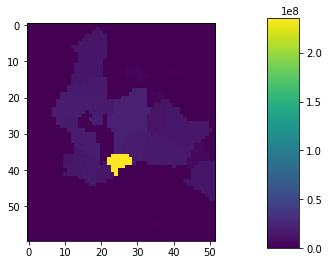

In [131]:
region_all = np.zeros(im1.shape)

for l in np.unique(labels.flatten()):
    sample = W1_nonsat*(labels==l)
    masksize = np.sum(sample.flatten()>0)
    lightpeak = sample.flatten().max()
    region_all =region_all + (labels==l)*lightpeak    


plt.imshow(region_all**2)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=cax)

plt.show()

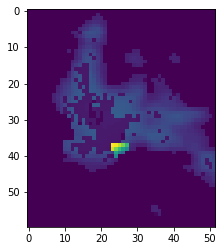

# Ideas

1) Podemos descomponer la imagenen en polígonos convexos (convex hull).

2) Cada polígono representaría una aproximación de la contaminación lumínica en una región dado por un sensor. (Por ejemplo este puede ser el valor maximo de intensidad registrada en la región)

3) Podríamos variar el numero de polígonos para controlar el detalle de la aproximación.

4) El número de polígonos podría estar en función del número de sensores. 

5) Para priorizar localiacion de sensores, ademas de considerar: 

1) la intensidad de la luz  
2) La clase a la que perteneces la región  

Considerar:  
3) la extensión que la medición de este sensor representaría.
    
Por ejemplo, si hay dos sensores con la misma "calificación" desempatar con la región que este representa. Pondríamos un sensor en el polígono mas grande, aunque este tenga la misma intensidad y misma clase.
    
    

Borrar el contenido de relleno de la plantilla
Ir escribiendo lo que llevamos.
